# Mini-projet d'optimisation : Effacement de consommation

## 1. Etude du problème d'optimisation

1. La facture d'énergie s'écrit comme l'intégrale de la puissance électrique consommée multipliée par le prix de l'énergie sur une période de temps donnée.
 En discrétisant le temps, on peut écrire la facture d'énergie comme la somme des puissances électriques consommées multipliée par le prix de l'énergie sur chaque intervalle de temps.
 Ainsi : 
 $$\text{Facture} = \Delta t \sum_{i=0}^{N-1} c_i P_i$$

2. Le bilan énergétique de la maison s'écrit :
- $P$ la puissance thermique produite par les convecteurs.
- $C \frac{dT}{dt}$ la puissance thermique absorbée par les murs et l'air dans la maison (on considère un système dynamique, la maison étant de capacité calorifique $C$)
- $H(T-T^e)$ la puissance thermique dissippée à l'exérieur par les murs et les fenêtres, avec le coefficient d'échange conducto-convectif $H$.

Ainsi, le bilan énergétique s'écrit :
$$P = C \frac{dT}{dt} + H(T-T^e) $$

La solution de ce problème s'écrit :
$$T(t) = T^e + \frac{P}{H} + (T_0 - T^e - \frac{P}{H})e^{-\frac{H}{C}t}$$

Ce qui se discrétise en :
$$T_{i+1} = T^e_i + \frac{P_i}{H} + (T_i - T^e_i - \frac{P_i}{H})e^{-\frac{H}{C}\Delta t}$$



On identifie alors h, k et b :

pour obtenir :
$$T_{i+1} = e^{-(k+h)\Delta t} T_i + \frac{1-e^{-(k+h)\Delta t}}{k+h} (bP_i + hT_i^e)$$
3. On veut minimiser la facture . Donc le problème d'optimisation est $$\min_{P_i} = \Delta t \sum_{i=0}^{N-1} c_i P_i$$ 

Les variables de décision sont donc les $P_i$, au nombre de $n=N$. 



On a également les contraintes inégalités suivantes : 
$$(c_{I1})_i = T_m-T_i$$
$$(c_{I2})_i = T_i-T_M$$
$$(c_{I3})_i = -P_i$$
$$(c_{I4})_i = P_i-P_M$$

On a en itérant sur $i$ que $$T_i = e^{-i(k+h)}T_0+\frac{1-e^{-(k+h)}}{k+h}\sum_{j=0}^{i-1}(bP_j+T_j^e)e^{-(i-1-j)(k+h)}$$ donc les conditions portent bien sur les $P_i$.

La fonction $f$ est définie par :
$$f(P) = \Delta t \sum_{i=0}^{N-1} c_i P_i$$


4. Les $c_i$ sont constants. Donc la fonction $f$ est linéaire en $P$. Le problème est donc un problème d'optimisation linéaire.

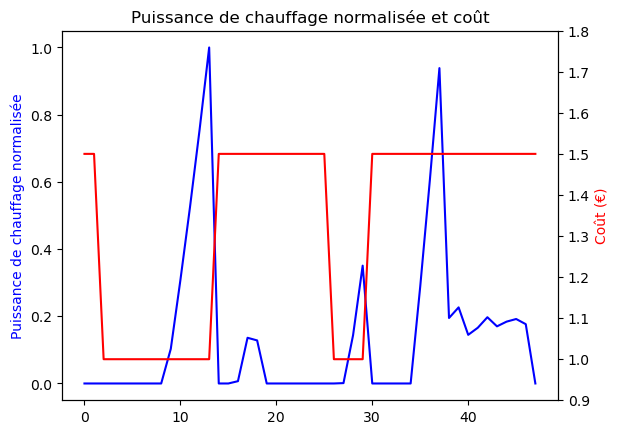

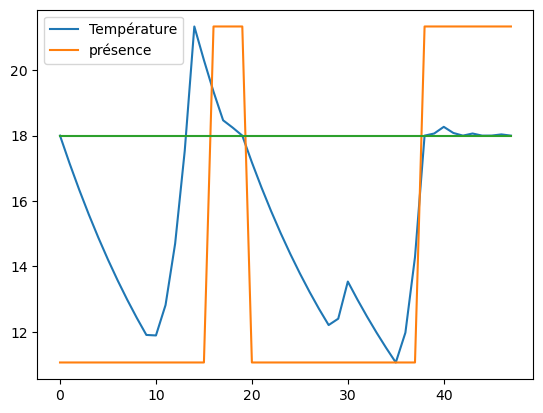

In [46]:
##Question 6



##definition des ti
import numpy as np
t0 = -1
deltat = 0.5
ti = np.array([(t0 + i*deltat)%24 for i in range(0, 48)])
Tiext = np.exp(-(ti-12)**2/40) +4

#print(ti)
#print(Tiext)

##Constantes
ccr=1
cpl=1.5
Tm=18
TM=30
h=0.05
k=0.01
b=1/500
PM=5000
cst = np.exp(-(h+k))

ci = np.array([cpl]*2+[ccr]*12+[cpl]*12+[ccr]*4+[cpl]*18)
presence = np.array([0]*16+[1]*4+[0]*18+[1]*10)
#print(ci*presence)


def Temp(P):
    Ti = np.zeros(48)
    Ti[0] = Tm
    for i in range(1, 48):
        Ti[i] = cst*Ti[i-1] +(1-cst)/(h+k)*(b*P[i-1]+h*Tiext[i-1])
    return Ti

##Contraintes
def C1(P):
    return P
def C2(P):
    return PM-P
def C3(P):
    return (Temp(P)-Tm)*presence
def C4(P):
    return (TM-Temp(P))*presence

##Fonction objectif
def f(P):
    sum=0
    for i in range(0, 48):
        sum+=ci[i]*P[i]
    return sum

##Conditions initiales
P0 = np.array([0]*48)

##Contraintes
constraints = [{'type': 'ineq', 'fun': C1},
               {'type': 'ineq', 'fun': C2},
               {'type': 'ineq', 'fun': C3},
               {'type': 'ineq', 'fun': C4}]

##Résolution
from scipy.optimize import minimize
res = minimize(f, P0, constraints=constraints)

##Affichage
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = plt.twinx()
ax1.plot( res.x/np.max(res.x), 'b')
ax1.set_ylabel('Puissance de chauffage normalisée', color='b')
ax2.plot(ci, 'r')
ax2.set_ylim(0.9,1.8)
ax2.set_ylabel('Coût (€)', color='r')
plt.title('Puissance de chauffage normalisée et coût')
plt.show()

plt.figure(2)
plt.plot( Temp(res.x))
plt.plot(presence*(21.3386185-11.06211968)+11.06211968)
plt.plot([18]*48)
plt.legend(['Température','présence'])
plt.show()

#print(Temp(res.x))


7. On voit que pour différentes valeurs du coût en heure pleine, le profil de puissance optimal est différent. En particulier, pour $c_{pl}=3.5$ on obtient un profil où toute la puissance est fornie en heure creuse. Et pour $c_{pl}=1.5$ on obtient un profil où de la puissance est aussi fournie en heure pleine.
On observe directement les effets incitatifs des régulations des prix pour soulager le réseau de distribution: il est moins cher de se chauffer en heure creuse qu'en heure pleine, quitte à augmenter la puissance fournie en heure creuse pour compenser.

## 3. Régulation collective

8. La fonction f à minimiser est désormais : 

$$ f(P) = \Delta t \sum_{i=0}^{N-1} c_i \Biggl( \sum_{j=0}^{n_l-1}P_i^j \Biggr) $$

Où $P$, le vecteur des  $P_i^j$, constitue la variable de décision. Les $P_i^j$ sont au nombre de $N \cdot n_l$.

Cette fois, on a les contraintes inégalités suivantes, pour tous $i, j \in [\![0, N-1]\!]  \times [\![0, n_l-1]\!]$ :

$$ (c_{I1})_{i,j} = T_m^j-T_i^j $$
$$ (c_{I2})_{i,j} = T_i^j - T_M^j $$
$$ (c_{I3})_{i,j} = -P_i^j $$
$$ (c_{I4})_{i,j} = P_i^j - P_M $$

Le problème s'écrit donc : $$\min_{P} f(P)$$ où $P$ est un vecteur de taille $N \cdot n_l$.

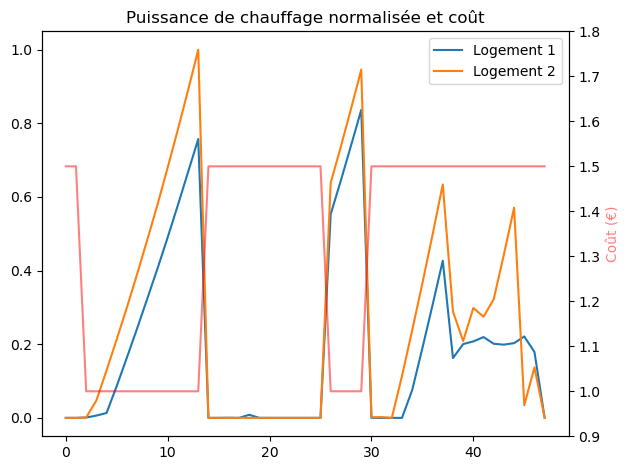

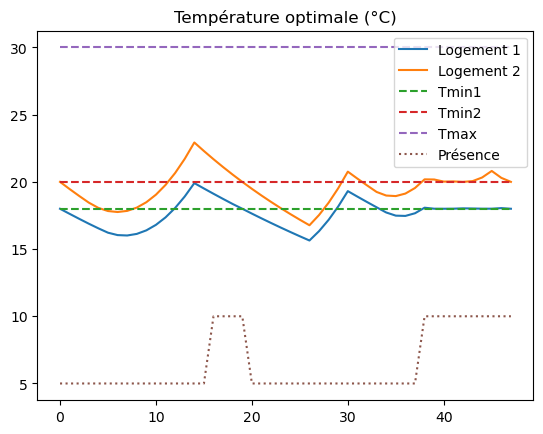

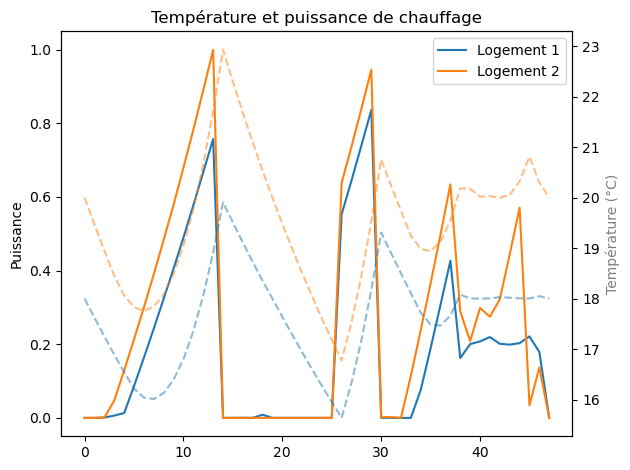

In [49]:
##Question 10
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

##Constantes
ccr=1
cpl=1.5
Tm1=18
Tm2=20
TM=30
h=0.05
k=0.01
b=1/500
PM=5000
n_l = 2
dt = 0.5
t0 = 23
n= int((t0+1)/dt)
N = n*n_l
cst = np.exp(-(2*h+k)*dt)
presence = np.array([0]*16*n_l+[1]*4*n_l+[0]*18*n_l+[1]*10*n_l)

Tiext2 = np.zeros(N)
Tiext2[::2]=Tiext
Tiext2[1::2]=Tiext

#Définition de la fonction de température
def Temp(P):
    Ti = np.zeros(N)
    Ti[:2] = np.array([Tm1,Tm2])
    for i in range(2, N, n_l):
        Ti[i] = cst*Ti[i-2] +(1-cst)/(2*h+k)*(b*P[i-2]+h*Tiext[i//n_l-1]+h*Ti[i-1])
        Ti[i+1] = cst*Ti[i-1] +(1-cst)/(2*h+k)*(b*P[i-1]+h*Tiext[i//n_l-1]+h*Ti[i-2])
    return Ti

##Contraintes
def C1(P):
    return P
def C2(P):
    return PM-P
def C3(P):
    res = np.zeros(N)
    res[::n_l] = (Temp(P)[::n_l]-Tm1)
    res[1::n_l] = (Temp(P)[1::n_l]-Tm2)
    return res*presence
def C4(P):
    return (TM-Temp(P))*presence

constraints = [{'type': 'ineq', 'fun': C1},
               {'type': 'ineq', 'fun': C2},
               {'type': 'ineq', 'fun': C3},
               {'type': 'ineq', 'fun': C4}]

##Fonction objectif
ci = np.array([cpl]*2+[ccr]*12+[cpl]*12+[ccr]*4+[cpl]*18)
def f(P):
    return dt*np.dot(ci, P[::n_l]+P[1::n_l])

##Conditions initiales
P0 = np.array([0]*N)

##Résolution
res = minimize(f, P0, constraints=constraints)
Puissance = res.x
PuissanceNormalisée = Puissance/np.max(Puissance)

fig, ax1 = plt.subplots()
ax2 = plt.twinx()
ax1.plot(PuissanceNormalisée[::n_l])
ax1.plot(PuissanceNormalisée[1::n_l])
ax1.legend(['Logement 1', 'Logement 2'])
ax2.plot(ci, 'r', alpha=0.5)
ax2.set_ylim(0.9,1.8)
ax2.set_ylabel('Coût (€)', color='r', alpha=0.5)
plt.title('Puissance de chauffage normalisée et coût')
plt.tight_layout()
plt.show()

plt.figure(2)
plt.plot(Temp(res.x)[::n_l])
plt.plot(Temp(res.x)[1::n_l])
plt.plot([Tm1]*n, linestyle='--')
plt.plot([Tm2]*n, linestyle='--')
plt.plot([TM]*n, linestyle='--')
plt.plot((presence[::n_l]+1)*5, linestyle=':')
plt.title('Température optimale (°C)')
plt.legend(['Logement 1', 'Logement 2', 'Tmin1', 'Tmin2', 'Tmax', 'Présence'])
plt.show()

fig, ax1 = plt.subplots()
ax2 = plt.twinx()
ax1.plot(PuissanceNormalisée[::n_l])
ax1.plot(PuissanceNormalisée[1::n_l])
ax1.legend(['Logement 1', 'Logement 2'])
ax1.set_ylabel('Puissance')
ax2.plot(Temp(res.x)[::n_l], alpha=0.5, linestyle='--')
ax2.plot(Temp(res.x)[1::n_l], alpha=0.5, linestyle='--')
ax2.set_ylabel('Température (°C)', alpha=0.5)
plt.title('Température et puissance de chauffage')
plt.tight_layout()
plt.show()

11. (a) Pour notre problème, l'algorithme de décomposition/coordination s'écrit comme suit : 
$$\forall (i,j) \in [\![1,N]\!] \times [\![1, n_l]\!], \min_{P_i^j} f_{ij}(P_i^j) + \sum_{l \in L} {\lambda_l^k c_ij(P_i^j)} $$ 
où $f_{ij}(P_i^j) = c_i P_i^j$.


11. (b) Il est impossible de résoudre le problème (14) pour la fonction coût (5), car on ne peut pas séparer les contraintes en une somme de différents termes ne dépendant que d'une seule variable. On ne peut donc pas utiliser un algorithme de décomposition/coordination. On utilise alors un coût modifié avec un terme quadratique additionnel pour pouvoir séparer les contraintes.
Ce terme quadratique va en effet faire tendre la


In [ ]:
#Question 11(d)

##Constantes
ccr=1
cpl=1.5
Tm1=18
Tm2=20
TM=30
h=0.05
k=0.01
b=1/500
PM=5000
n_l = 2
dt = 0.5
t0 = 23
n= int((t0+1)/dt)
N = n*n_l
cst = np.exp(-(2*h+k)*dt)
presence = np.array([0]*16*n_l+[1]*4*n_l+[0]*18*n_l+[1]*10*n_l)

Tiext2 = np.zeros(N)
Tiext2[::2]=Tiext
Tiext2[1::2]=Tiext

#initailisation
epsilon = 0.01
lambda = np.array([0]*n)
rho = 0.1
Niter = 40
k = 0

while k<=Niter : 
    lambdakplusun = 
    test = np.norm(lambdakplusun - lambda)
    if test < epsilon :
        break
    else :
        lambda = lambdakplusun
        k+=1
        continue